# Basic Calcium Imaging Pipeline Using PCA-ICA
### Example with 4 rat videos
Importing Libraries and Videos for Data Analysis:

In [1]:
import os  #operating system
import textwrap  # to format multiline string text
from glob import glob
from itertools import chain  # list manipulation
from pathlib import Path  # to work with directories

import isx  # Inscopix API
import matplotlib.pyplot as plt  # data visualization
import numpy as np  # to manipulate data matrix
import pandas as pd  # data analysis library
import seaborn as sns 
from isxtools import isx_files_handler, plot_max_dff_and_cellmap_fh
from scipy import stats  # statistics library

sns.set_style("darkgrid")
folder = Path("I:\\Cohort 1")
subfolders = ["D1-838\\D1-838_StressDay_10121"] * 4
filepattern = [
    "2021-10-01-11-27-26_video_trig_0.isxd",
    "2021-10-01-12-07-09_video_trig_0.isxd",
    "2021-10-01-13-42-25_video_trig_0.isxd",
    "2021-10-01-14-14-37_video_trig_0.isxd",
]

outputsfolder = "I:\\pipeline_output_data"
files_handler = isx_files_handler(
    folder,
    subfolders,
    filepattern,
    outputsfolder,
    processing_steps=["trim", "PP", "BP", "MC"],
)

from itertools import product

session_names = ["P1", "S1", "S2", "P2"]
newlabels = [x + "_" + y for x, y in product(["D1-838"], session_names)]
rats_ID = ["838"] * 4
cell_types = ["D1"] * 4
video_len_seconds = int(29.5 * 60) #setting the length of the video 

In [2]:
#create a table with video metadata
video_data = []
for file in files_handler.rec_names:
    movie = isx.Movie.read(file)
    video_data.append(
        {
            "resolution": movie.spacing.num_pixels,
            "duration": movie.timing.num_samples
            * movie.timing.period.to_msecs()
            / 1000,
            "sampling_rate": 1 / (movie.timing.period.to_msecs() / 1000),
            "file": Path(file),
            "fname": str(Path(file).name),
            "folder": str(Path(file).parent.name),
        }
    )
    movie.flush()
df_vd = pd.DataFrame(video_data).set_index("file").sort_values(by=["fname"])

Checking the length of videos

In [3]:
df_vd.duration > video_len_seconds

file
I:\Cohort 1\D1-838\D1-838_StressDay_10121\2021-10-01-11-27-26_video_trig_0.isxd    True
I:\Cohort 1\D1-838\D1-838_StressDay_10121\2021-10-01-12-07-09_video_trig_0.isxd    True
I:\Cohort 1\D1-838\D1-838_StressDay_10121\2021-10-01-13-42-25_video_trig_0.isxd    True
I:\Cohort 1\D1-838\D1-838_StressDay_10121\2021-10-01-14-14-37_video_trig_0.isxd    True
Name: duration, dtype: bool

Trimming the videos to the same length 

In [4]:
overwrite = False
verbose = False
print("Trim movies...\n")
for vi,(input, output) in enumerate(files_handler.get_pair_filenames('trim')):
    endframe = video_len_seconds*df_vd.sampling_rate[vi]
    maxfileframe = endframe * 100  # removing up to the last frames
    if overwrite and os.path.exists(output):
        os.remove(output)
    if not os.path.exists(output):
        isx.trim_movie(
            input_movie_file=input,  
            output_movie_file=output, 
            crop_segments=np.array([[endframe, maxfileframe]]),
        )
        if verbose:
            print("{} trimming completed".format(output))
        assert os.path.exists(output), "File not created: {}".format(output)
    else:
        if verbose:
            print(output + " already exists, series skipped")
print("done")

Trim movies...

done


This Cell preprocesses the videos and apply a spatial filter.
Preprocessing removes artifacts from the videos and reduces the size of the videos.
The Spatial filter removes the low and high frequency contents (removes noise).


In [5]:
# print('Preprocessing, please wait...\n')
overwrite = False
verbose = False
for input, output in files_handler.get_pair_filenames("PP"):
    sp_downsampling = 1
    tp_downsampling = 1

    if overwrite and os.path.exists(output):
        os.remove(output)
    if not os.path.exists(output):
        isx.preprocess(
            input_movie_files=input,
            output_movie_files=output,
            temporal_downsample_factor=tp_downsampling,
            spatial_downsample_factor=sp_downsampling,
            crop_rect=None,
            fix_defective_pixels=True,
        )
        if verbose:
            print("{} preprocessing completed".format(output))
    else:
        if verbose:
            print(output + " already exists, series skipped")
print("Applying bandpass filter, please wait...\n")

for input, output in files_handler.get_pair_filenames("BP"):
    if overwrite and os.path.exists(output):
        os.remove(output)
    if not os.path.exists(output):
        isx.spatial_filter(
            input_movie_files=input,
            output_movie_files=output,  
            low_cutoff=0.005,
            high_cutoff=0.5,
            retain_mean=False,
            # leave subtract_global_minimum setting as true for correct dff display
            subtract_global_minimum=True,
        )
        if verbose:
            print("{} bandpass filtering completed".format(output))
    else:
        if verbose:
            print(output + " already exists, series skipped")
print("done")

Applying bandpass filter, please wait...

done


This next applies motion correction to the videos removing any movement so the pixels align with the field of view in all frames.

In [6]:
overwrite = False
verbose = False
for input, output in zip(
    files_handler.get_filenames("BP"),
    files_handler.get_results_filenames("mean_image", op="BP"),
):
    if overwrite and os.path.exists(output):
        os.remove(output)
    if not os.path.exists(output):
        isx.project_movie(
            input_movie_files=input, output_image_file=output, stat_type="mean"
        )  
        if verbose:
            print(f"{output} temporal projection completed, new file has been generated and will be used as a reference frame for motion correction")
    else:
        if verbose:
            print(output + " already exists, projection process skipped")

print("Applying motion correction. Please wait...\n")
mean_proj_files = files_handler.get_results_filenames("mean_image", op="BP")
translation_files = files_handler.get_results_filenames("translations.csv", op="BP")
crop_rect_files = files_handler.get_results_filenames("crop_rect.csv", op="BP")
for i, (input, output) in enumerate(files_handler.get_pair_filenames("MC")):
    if overwrite and os.path.exists(output):
        os.remove(output)
    if not os.path.exists(output):
        isx.motion_correct(
            input_movie_files=input,
            output_movie_files=output,
            max_translation=20,
            roi=None,
            reference_segment_index=0,  
            reference_frame_index=0,  
            reference_file_name=mean_proj_files[
                i
            ],
            global_registration_weight=1.0,
            output_translation_files=translation_files[i],
            output_crop_rect_file=crop_rect_files[i],
        )
        if verbose:
            print("{} motion correction completed".format(output))
    else:
        if verbose:
            print(output + " already exists, series skipped")
print("done")

Applying motion correction. Please wait...

done


DeltaF/F0 normalizes the pixel values in the movies so that the variation in intensity is not due to spatial variation

In [7]:
# use for loop to calculate deltaF/F0
print("Calculating deltaf/f0, please wait...\n")
verbose = False
overwrite = False
for input, output in zip(
    files_handler.get_filenames("MC"),
    files_handler.get_results_filenames("dff", op="MC"),
):
    if overwrite and os.path.exists(output):
        os.remove(output)
    if not os.path.exists(output):
        isx.dff(input_movie_files=input, output_movie_files=output, f0_type="mean")
        if verbose:
            print("A new df/f movie has been generated for", output)
    else:
        print(output + " already exists, process skipped")
print("Projecting movies, please wait...\n")
# use for loop to project movies
for input, output in zip(
    files_handler.get_results_filenames("dff", op="MC"),
    files_handler.get_results_filenames("maxdff", op="MC"),
):
    if overwrite and os.path.exists(output):
        os.remove(output)
    if not os.path.exists(output):
        isx.project_movie(
            input_movie_files=input, output_image_file=output, stat_type="max"
        )
        if verbose:
            print("Maximal projection from {} dff time series completed".format(output))
    else:
        print(output + " already exists, process skipped")
print("done")

Calculating deltaf/f0, please wait...

I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-11-27-26_video_trig_0-trim-PP-BP-MC-dff.isxd already exists, process skipped
I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-12-07-09_video_trig_0-trim-PP-BP-MC-dff.isxd already exists, process skipped
I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-13-42-25_video_trig_0-trim-PP-BP-MC-dff.isxd already exists, process skipped
I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-14-14-37_video_trig_0-trim-PP-BP-MC-dff.isxd already exists, process skipped
Projecting movies, please wait...

I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-11-27-26_video_trig_0-trim-PP-BP-MC-maxdff.isxd already exists, process skipped
I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-12-07-09_video_trig_0-trim-PP-BP-MC-maxdff.isxd already exists, process skipped
I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-13-

The PCA-ICA algorithm identifies the spatial location of cells in the video and their associated activity using the principal and independent components of the video.

In [8]:
print(
    """Applying PCA-ICA algorithm to segment cells.
Please wait...\n"""
)
overwrite = False
verbose = False

for input, output in zip(
    files_handler.get_results_filenames("dff", op="MC"),
    files_handler.get_results_filenames("pca-ica-cellset", op="MC"),
):
    if overwrite and os.path.exists(output):
        os.remove(output)

    num_pcs = 50 #this value is just for the example
    # you can use: isx.estimate_num_ics to help you find your values
    num_ics = int(num_pcs / 1.2)
    

    if not os.path.exists(output):
        isx.pca_ica(
            input_movie_files=input,
            output_cell_set_files=output,
            num_pcs=num_pcs,
            num_ics=num_ics,
            unmix_type="both",
            max_iterations=400,
            ica_temporal_weight=0.01,
            convergence_threshold=1e-05,
            block_size=4000,
        )
        if verbose:
            print(
                "PCA-ICA analysis completed."
                + "A  files ha been generated {} .".format(output)
            )
    else:
        if verbose:
            print(output + " already exists, process skipped")
print("done")

Applying PCA-ICA algorithm to segment cells.
Please wait...

done


Event Detection allows cells to be identified when they have an activity 

In [9]:
overwrite = False
verbose = False
for input, output in zip(
    files_handler.get_results_filenames("pca-ica-cellset", op="MC"),
    files_handler.get_results_filenames("pca-ica-event", op="MC"),
):
    if overwrite and os.path.exists(output):
        os.remove(output)
    if not os.path.exists(output):
        isx.event_detection(
            input_cell_set_files=input,
            output_event_set_files=output,
            threshold=6,  # sigma threshold; this value is just for the example.
            #low threshold=high noise, high threshold=few events
            tau=0.2,  # default is 200ms for Gcamp6f 
            event_time_ref="beginning",  # export other timing separately
            ignore_negative_transients=True,
            accepted_cells_only=False,
        )
        if verbose:
            print("Event detection completed for {}".format(output))
    else:
        print(output + " already exists, process skipped")

I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-11-27-26_video_trig_0-trim-PP-BP-MC-pca-ica-event.isxd already exists, process skipped
I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-12-07-09_video_trig_0-trim-PP-BP-MC-pca-ica-event.isxd already exists, process skipped
I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-13-42-25_video_trig_0-trim-PP-BP-MC-pca-ica-event.isxd already exists, process skipped
I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-14-14-37_video_trig_0-trim-PP-BP-MC-pca-ica-event.isxd already exists, process skipped


This cell calculates the cell metrics

In [10]:
overwrite = False
df_full = []
for raw_name, cellset, events, output in zip(
    files_handler.rec_names,
    files_handler.get_results_filenames("pca-ica-cellset", op="MC"),
    files_handler.get_results_filenames("pca-ica-event", op="MC"),
    files_handler.get_results_filenames("CellMetrics.csv"),
):
    if overwrite and os.path.exists(output):
        os.remove(output)
    isx.cell_metrics(cellset, events, output)
    cell_set = isx.CellSet.read(cellset)  # load the cells
    num_cells = cell_set.num_cells  # retrieve cell number
    # set cell filter to label cells that match the input index list
    # initiation with false boolean
    accepted = [False for i in range(num_cells)]
    for cell in range(num_cells):
        if cell_set.get_cell_status(cell) == "accepted":
            accepted[cell] = True

    df = pd.read_csv(output)

    df["accepted"] = accepted
    df.to_csv(output)
    df["raw_name"] = raw_name
    df_full.append(df)
df_full = pd.concat(df_full)

This filters accepted cells based on different cell criteria

In [11]:
events_filters = [
    ("SNR", ">", 2), 
    ("Event Rate", ">", 0),
    ("# Comps", "<", 3),
    ("Cell Size", "<", 50), # cell size depends on the resolution and the spatial downsampling of the video
    ("Cell Size", ">", 5),
]

for input_cellset, input_events in zip(
    files_handler.get_results_filenames("pca-ica-cellset", op="MC"),
    files_handler.get_results_filenames("pca-ica-event", op="MC"),
):

    isx.auto_accept_reject(
        input_cell_set_files=input_cellset,
        input_event_set_files=input_events,
        filters=events_filters,
    )
    print(
        "Auto classification completed (cellset updated) for {}.".format(input_cellset)
    )
print('done')

Auto classification completed (cellset updated) for I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-11-27-26_video_trig_0-trim-PP-BP-MC-pca-ica-cellset.isxd.
Auto classification completed (cellset updated) for I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-12-07-09_video_trig_0-trim-PP-BP-MC-pca-ica-cellset.isxd.
Auto classification completed (cellset updated) for I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-13-42-25_video_trig_0-trim-PP-BP-MC-pca-ica-cellset.isxd.
Auto classification completed (cellset updated) for I:\pipeline_output_data\D1-838\D1-838_StressDay_10121\2021-10-01-14-14-37_video_trig_0-trim-PP-BP-MC-pca-ica-cellset.isxd.
done


Creates a cell map of accepted cells

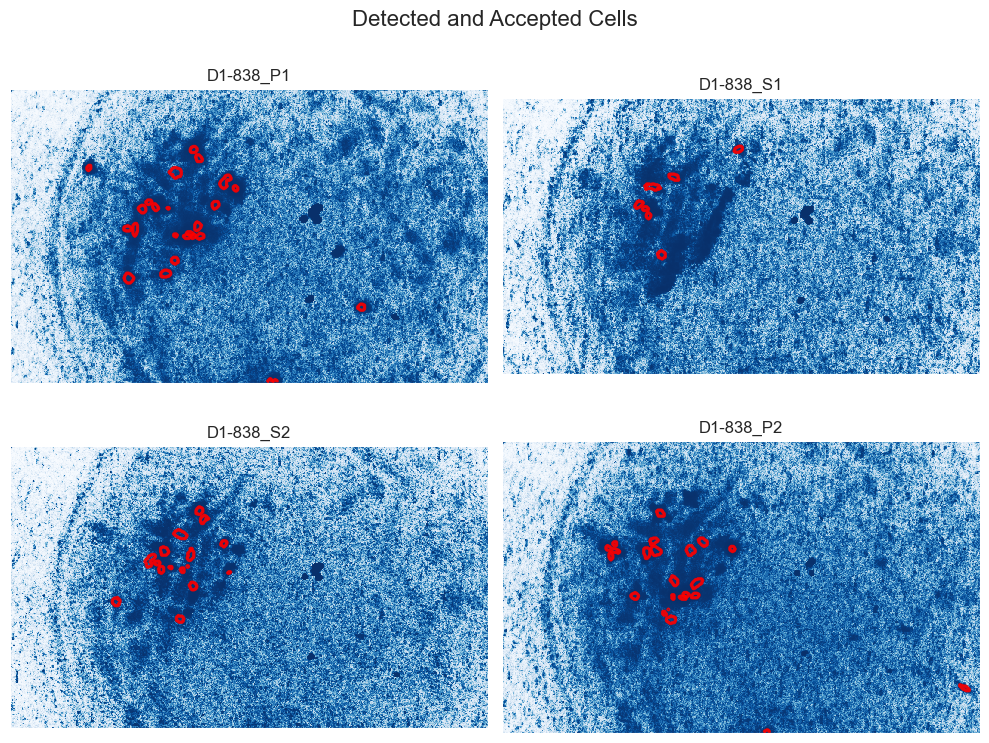

In [19]:
import warnings
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(10, 8))
for i, raw in enumerate(files_handler.rec_names):
    plt.subplot(2, 2, i+ 1 + i // 4)
    cell_image = plot_max_dff_and_cellmap_fh(
        files_handler,
        idx=i,
        eqhist=True,
        cellsetname="pca-ica-cellset",
        status_list=["accepted"],
    )
    plt.title(newlabels[i])
    plt.xticks([])
    plt.yticks([])
fig.suptitle('Detected and Accepted Cells', fontsize=16)

plt.tight_layout()

Creates a plot of the cell traces

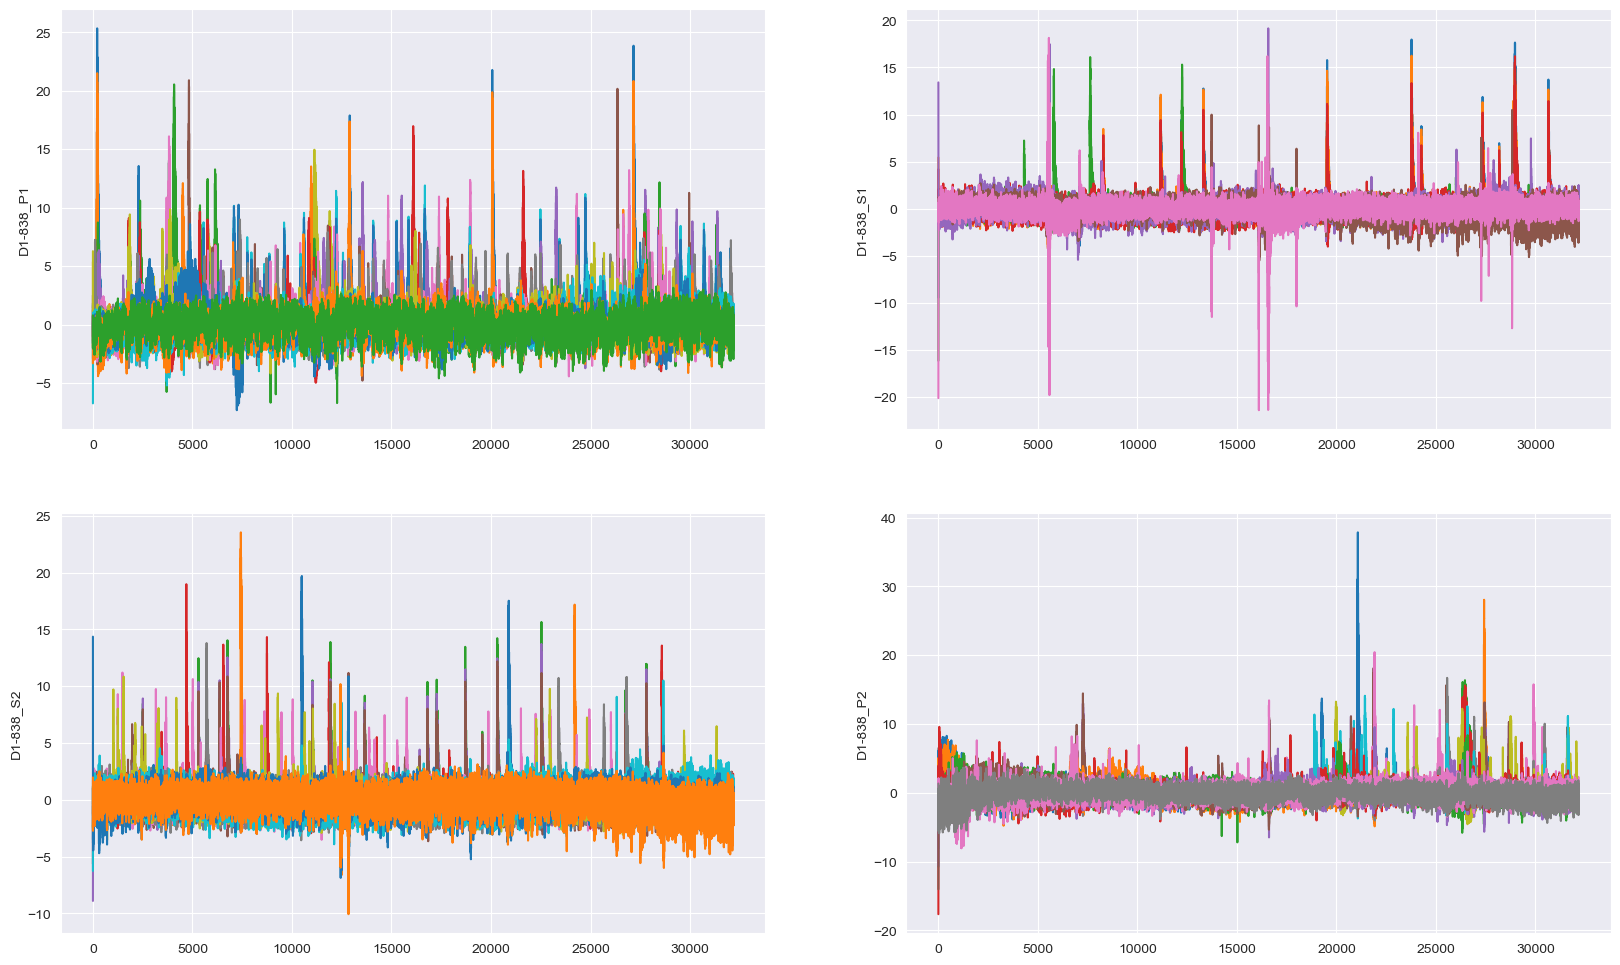

In [13]:
plt.figure(figsize=(20, 12))
for fi, (name, cellset) in enumerate(
    zip(newlabels, files_handler.get_results_filenames("pca-ica-cellset", op="MC"))
):
    plt.subplot(2, 2, fi+ 1+ fi // 4)
    cs = isx.CellSet.read(cellset)
    for n in range(cs.num_cells):
        if cs.get_cell_status(n) == "accepted":
            plt.plot(cs.get_cell_trace_data(n))
    plt.ylabel(name)
   

Creates the data to calculate the firing rate (events per minute) of the cells

In [14]:
metadata = pd.DataFrame({'file':files_handler.get_results_filenames("pca-ica-cellset", op="MC"),
                         'animal_id':rats_ID,
                         'session_name': session_names
                        })

events_df = []
for cellset, events in zip(
    files_handler.get_results_filenames("pca-ica-cellset", op="MC"),
    files_handler.get_results_filenames("pca-ica-event", op="MC"),
):
    ev = isx.EventSet.read(events)
    cs = isx.CellSet.read(cellset)
    for n in range(cs.num_cells):
        if cs.get_cell_status(n) == "accepted":
            events_df.append(
                pd.DataFrame(
                    {
                        "file": cellset,
                        "events_us": ev.get_cell_data(n)[0],
                        "cell_name": cs.get_cell_name(n),
                    }
                )
            )
events_df = pd.concat(events_df)
events_df["minutes"] = events_df["events_us"] / (60 * 1e6)
events_df = events_df.merge(metadata, on=["file"])
firing_rate = pd.DataFrame(
    events_df.groupby(["file", "cell_name"]).count()["events_us"]
)
firing_rate["#events/minute"] = firing_rate["events_us"] / (video_len_seconds / 60)
firing_rate = firing_rate.merge(metadata, on=["file"])

Example of bar graph to plot firing rate

Text(0.5, 1.0, 'Mean Firing Rate')

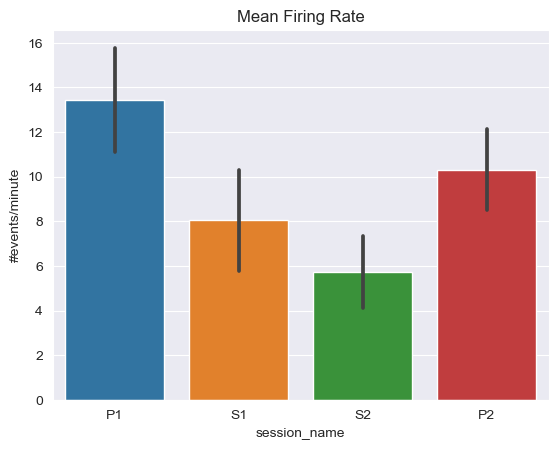

In [15]:
sns.barplot(
    data=firing_rate,
    x="session_name",
    y="#events/minute",
    errorbar="se",
)
plt.title("Mean Firing Rate")

Calculates the cumulative events over each session

In [16]:
times = np.linspace(
    0, video_len_seconds / 60, int(video_len_seconds * 2 / 60)
)  # 2 points per minute
cum_events_df = []
for file in events_df.file.unique():
    for cell in events_df[events_df.file == file]["cell_name"].unique():
        evs = np.sort(
            events_df[(events_df["cell_name"] == cell) * (events_df.file == file)][
                "minutes"
            ].values
        )
        calc_cum_events = np.vectorize(lambda x: sum(evs < x))
        cum_events = calc_cum_events(times)

        cum_events_df.append(
            pd.DataFrame(
                {   "file": file,
                    "cell_name": cell,
                    "Time (minutes)": times,
                    "cumulative events": cum_events.copy(),
                }
            )
        )


cum_events_df = pd.concat(cum_events_df)
cum_events_df = cum_events_df.merge(metadata, on=["file"])
display(cum_events_df)

,file,cell_name,Time (minutes),cumulative events,animal_id,session_name
0,I:\pipeline_output_data\D1-838\D1-838_StressDa...,C01,0.000000,0,838,P1
1,I:\pipeline_output_data\D1-838\D1-838_StressDa...,C01,0.508621,89,838,P1
2,I:\pipeline_output_data\D1-838\D1-838_StressDa...,C01,1.017241,89,838,P1
3,I:\pipeline_output_data\D1-838\D1-838_StressDa...,C01,1.525862,89,838,P1
4,I:\pipeline_output_data\D1-838\D1-838_StressDa...,C01,2.034483,89,838,P1
...,...,...,...,...,...,...
3535,I:\pipeline_output_data\D1-838\D1-838_StressDa...,C39,27.465517,35,838,P2
3536,I:\pipeline_output_data\D1-838\D1-838_StressDa...,C39,27.974138,35,838,P2
3537,I:\pipeline_output_data\D1-838\D1-838_StressDa...,C39,28.482759,35,838,P2
3538,I:\pipeline_output_data\D1-838\D1-838_StressDa...,C39,28.991379,35,838,P2


Plots the event frequency of the cells during the recording

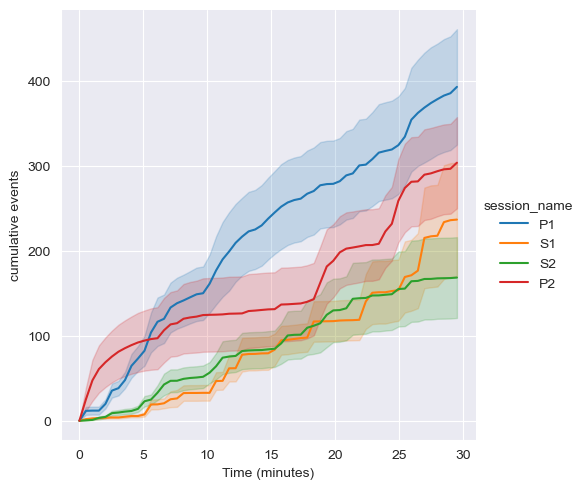

In [17]:
sns.relplot(
    x="Time (minutes)",
    y="cumulative events",
    hue="session_name",
    data=cum_events_df,
    kind="line",
    facet_kws={"sharey": False},
    errorbar="se",
)